# Importaciones de librerías necesarias

In [1]:
import h2o
from h2o.automl import H2OAutoML
import pandas as pd

# Datos Calidad del aire

In [2]:
#
# Fuente Original Calidad del Aire Córdoba - Estación LEPANTO
#
data_url = "grafana_data_export.csv"

In [4]:
#weather_df = pd.read_csv(data_url)
data = pd.read_csv(data_url, sep=';')

In [6]:
#
# Muestra Dataframe con TODOS los valores de archivo de importación
#
data.head()

,entity_ts,NO2,O3,PM10,PM25,SO2
0,2021-10-25T02:00:00+02:00,37.0,63.875,26.980000,10.000,5
1,2021-10-25T03:00:00+02:00,41.0,54.125,26.362000,9.833,5
2,2021-10-25T04:00:00+02:00,25.0,45.000,26.362000,9.875,5
3,2021-10-25T05:00:00+02:00,17.0,37.875,26.552000,10.000,5
4,2021-10-25T06:00:00+02:00,11.0,34.000,26.504999,10.125,5


In [7]:
#
# Re-convierte atributo fecha, genera índices y ordena por índice
#
data['entity_ts'] = pd.to_datetime(data['entity_ts'],utc=True)
data.set_index('entity_ts', inplace=True)
data.sort_values('entity_ts', inplace=True)


In [8]:
#
# Muestra dataframe replanteado
#
data

,NO2,O3,PM10,PM25,SO2
entity_ts,,,,,
2021-10-25 00:00:00+00:00,37.0,63.875,26.980000,10.000,5
2021-10-25 01:00:00+00:00,41.0,54.125,26.362000,9.833,5
2021-10-25 02:00:00+00:00,25.0,45.000,26.362000,9.875,5
2021-10-25 03:00:00+00:00,17.0,37.875,26.552000,10.000,5
2021-10-25 04:00:00+00:00,11.0,34.000,26.504999,10.125,5
...,...,...,...,...,...
2025-01-25 19:00:00+00:00,16.0,60.000,13.643000,6.795,3
2025-01-25 20:00:00+00:00,23.0,59.125,13.383000,6.840,3
2025-01-25 21:00:00+00:00,18.0,57.250,12.993000,6.750,3


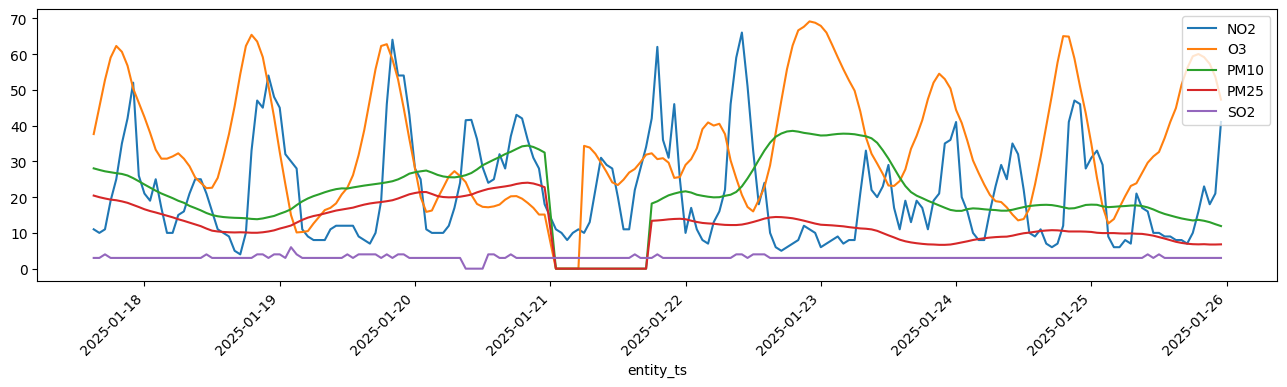

In [9]:
#
# Representa gráficamente los últimos 200 registros del dataframe
#
data.tail(200).plot(rot=45, figsize=(16,4)).legend(loc='upper right')

<Axes: xlabel='entity_ts'>

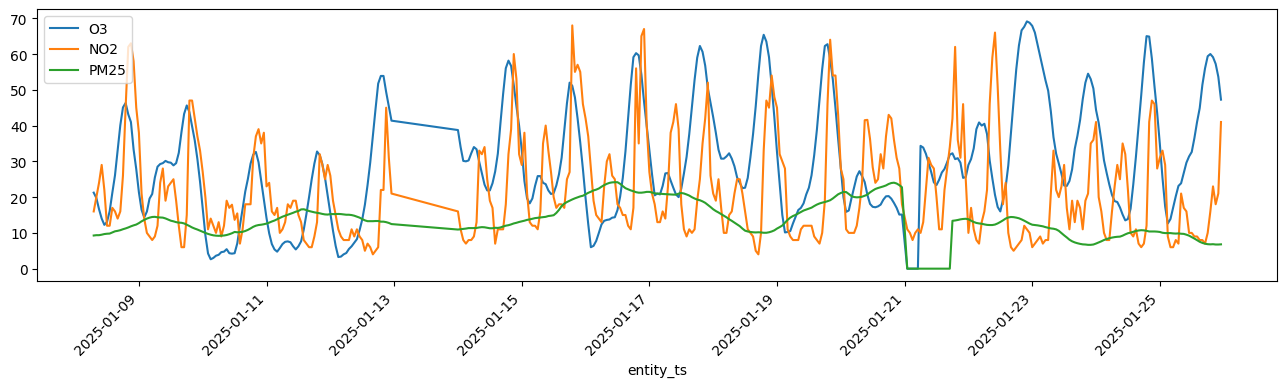

In [10]:
#
# Representa los 400 últimos registros del atributo O3
#
data.tail(400).plot(y=['O3', 'NO2','PM25'], rot=45, figsize=(16,4))

# Datos de la calidad del aire. Proceso de limpieza

In [11]:
#
# Copia del dataframe para curado de información
#
dataset = data

In [12]:
#
# Localización de valores nulos, conversión aplicando SUM()
#
dataset.isna().sum()

NO2     0
O3      0
PM10    0
PM25    0
SO2     0
dtype: int64

In [13]:
#
# Eliminación de valores nulos
#
dataset.dropna(inplace=True)

In [14]:
#
# Muestra primeros valores del dataframe de curado
#
dataset.head(6)

,NO2,O3,PM10,PM25,SO2
entity_ts,,,,,
2021-10-25 00:00:00+00:00,37.0,63.875,26.980000,10.000,5
2021-10-25 01:00:00+00:00,41.0,54.125,26.362000,9.833,5
2021-10-25 02:00:00+00:00,25.0,45.000,26.362000,9.875,5
2021-10-25 03:00:00+00:00,17.0,37.875,26.552000,10.000,5
2021-10-25 04:00:00+00:00,11.0,34.000,26.504999,10.125,5
2021-10-25 05:00:00+00:00,10.0,32.500,26.268000,10.125,5


### En una tarea de predicción requerimos de un columna objetivo, la construmimos:   Y(t) = Y(t+1)

In [15]:
#
# Consumo de columnas objetivo según Y(t) = Y(t-1)
#
dataset['O3+1'] = dataset['O3'].shift(-1)

#
# Eliminación de nulos
#
dataset.dropna(inplace=True)

#
# Muestra de los últimos registros
#
dataset.tail(6)

,NO2,O3,PM10,PM25,SO2,O3+1
entity_ts,,,,,,
2025-01-25 17:00:00+00:00,7.0,56.000,13.737,6.975,3,59.375
2025-01-25 18:00:00+00:00,10.0,59.375,13.477,6.840,3,60.000
2025-01-25 19:00:00+00:00,16.0,60.000,13.643,6.795,3,59.125
2025-01-25 20:00:00+00:00,23.0,59.125,13.383,6.840,3,57.250
2025-01-25 21:00:00+00:00,18.0,57.250,12.993,6.750,3,53.625
2025-01-25 22:00:00+00:00,21.0,53.625,12.429,6.750,3,47.250


In [16]:
#
# Summary
#
dataset.describe()

,NO2,O3,PM10,PM25,SO2,O3+1
count,28307.000000,28307.000000,28307.000000,28307.000000,28307.000000,28307.000000
mean,14.262047,54.090137,26.387620,11.898852,2.328576,54.089550
std,12.908942,29.519301,20.470197,6.405778,0.898803,29.519272
min,-1.681000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.000000,30.584499,16.469999,7.729000,2.000000,30.584499
50%,10.000000,52.625000,23.062000,10.880000,2.000000,52.625000
75%,19.000000,75.250000,31.465500,15.061000,3.000000,75.250000
max,102.000000,142.125000,552.567993,115.375000,18.000000,142.125000


<Axes: xlabel='entity_ts'>

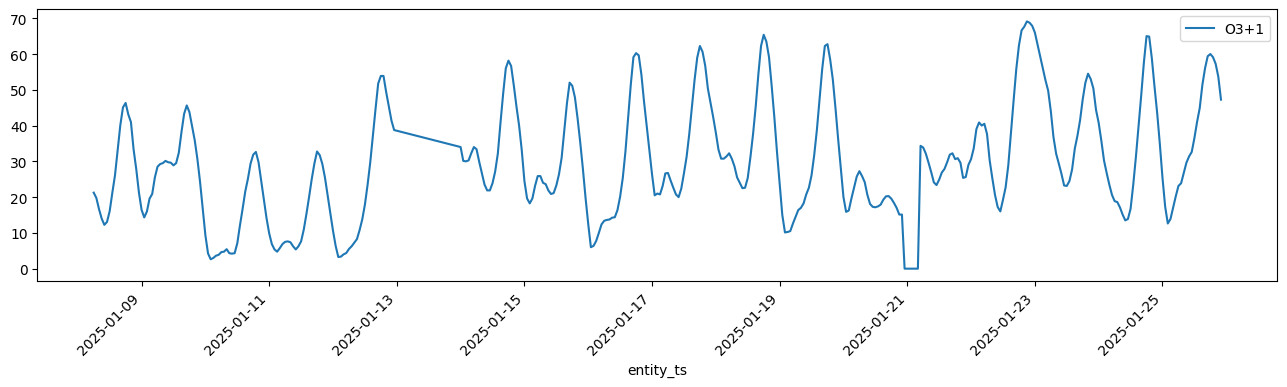

In [17]:
#
# Representación de los 400 últimos valores
#
dataset.tail(400).plot(y=['O3+1'], rot=45, figsize=(16,4))

### Ultimo paso, codificar la información de la fecha de medida del valor y eliminamos las columnas no necesarias

In [18]:
#
# Columnas Categorías relacionadas con las fechas
#
dataset['day'] = dataset.index.day.astype('category')
dataset['month'] = dataset.index.month.astype('category')
dataset['year'] = dataset.index.year.astype('category')
dataset['hour'] = dataset.index.hour.astype('category')
dataset['dayoftheweek'] = dataset.index.dayofweek.astype('category')

In [19]:
#
# Muestra dataframe de curado
#
dataset

,NO2,O3,PM10,PM25,SO2,O3+1,day,month,year,hour,dayoftheweek
entity_ts,,,,,,,,,,,
2021-10-25 00:00:00+00:00,37.0,63.875,26.980000,10.000,5,54.125,25,10,2021,0,0
2021-10-25 01:00:00+00:00,41.0,54.125,26.362000,9.833,5,45.000,25,10,2021,1,0
2021-10-25 02:00:00+00:00,25.0,45.000,26.362000,9.875,5,37.875,25,10,2021,2,0
2021-10-25 03:00:00+00:00,17.0,37.875,26.552000,10.000,5,34.000,25,10,2021,3,0
2021-10-25 04:00:00+00:00,11.0,34.000,26.504999,10.125,5,32.500,25,10,2021,4,0
...,...,...,...,...,...,...,...,...,...,...,...
2025-01-25 18:00:00+00:00,10.0,59.375,13.477000,6.840,3,60.000,25,1,2025,18,5
2025-01-25 19:00:00+00:00,16.0,60.000,13.643000,6.795,3,59.125,25,1,2025,19,5
2025-01-25 20:00:00+00:00,23.0,59.125,13.383000,6.840,3,57.250,25,1,2025,20,5


In [20]:
#
# Tipos de datos generados
#
dataset.dtypes

NO2              float64
O3               float64
PM10             float64
PM25             float64
SO2                int64
O3+1             float64
day             category
month           category
year            category
hour            category
dayoftheweek    category
dtype: object

# H2O AutoML:  Entrenar varios modelos y escoger el más apto

In [21]:
#
# Instancia y estado del cluster
#
h2o.init()
h2o.cluster().show_status(True)

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,1 day 14 hours 35 mins
H2O_cluster_timezone:,UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.6
H2O_cluster_version_age:,3 months and 8 days
H2O_cluster_name:,root
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.003 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


H2O_cluster_uptime:,1 day 14 hours 35 mins
H2O_cluster_timezone:,UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.6
H2O_cluster_version_age:,3 months and 8 days
H2O_cluster_name:,root
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.003 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Nodes info:,Node 1
h2o,/172.18.0.8:54321
healthy,True
last_ping,1739189573679.0000000
num_cpus,12
sys_load,2.869629
mem_value_size,734183342
free_mem,3223911368.0000000
pojo_mem,154420362
swap_mem,0
free_disk,317280223232.0000000


In [70]:
#
# Limpieza recuros del cluster h2o y listado de comprobación.
#
h2o.remove_all()
h2o.ls()


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


,key


## Subir el dataset al H2O

In [22]:
#
# Subimos los datos curados (dataframe) al cluster h2o (dataframe de h2o)
#
dataset_h2o = h2o.H2OFrame(dataset)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [23]:
#
# Mostramos dataframe de h2o en el cluster
#
dataset_h2o

NO2,O3,PM10,PM25,SO2,O3+1,day,month,year,hour,dayoftheweek
37,63.875,26.98,10,5,54.125,25,10,2021,0,0
41,54.125,26.362,9.833,5,45,25,10,2021,1,0
25,45,26.362,9.875,5,37.875,25,10,2021,2,0
17,37.875,26.552,10,5,34,25,10,2021,3,0
11,34,26.505,10.125,5,32.5,25,10,2021,4,0
10,32.5,26.268,10.125,5,30.625,25,10,2021,5,0
11,30.625,26.078,10.167,4,33,25,10,2021,6,0
9,33,25.935,10.125,5,34.125,25,10,2021,7,0
11,34.125,25.888,10.125,5,35,25,10,2021,8,0
17,35,25.745,10.083,5,35,25,10,2021,9,0


# Entrenar con H2O AutoML

In [24]:
#
# Librería de AutoML. Instancia h2o
#
from h2o.automl import H2OAutoML

In [25]:
#
# Elementos de generación de datos para entrenamiento (train, test, valid)
#
train, test, valid = dataset_h2o.split_frame(ratios=[.8, .15])

#
# Column to Predict
# Entrada (x) todo el dataframe
#
x = dataset_h2o.columns
#
# Salida (y) columna de predicción
#
y = 'O3+1'
#
# Eliminar columna de predicción en los datos de entrada (x)
#
x.remove('O3+1')

#
# Debug depuración
#
print(f'Datasets sizes | Train {train.shape} | Validation {valid.shape} | Test {test.shape}')
print(f'Columns Definiton | X: {x} |')
print(f'Columns Definiton | Y: {y} |')



Datasets sizes | Train (22479, 11) | Validation (1445, 11) | Test (4383, 11)
Columns Definiton | X: ['NO2', 'O3', 'PM10', 'PM25', 'SO2', 'day', 'month', 'year', 'hour', 'dayoftheweek'] |
Columns Definiton | Y: O3+1 |


In [26]:
#
# H2OAutoML: This is the core class for performing automated machine learning within the H2O framework.
#
# * max_models=20: This parameter limits the maximum number of models that AutoML will train. By default, AutoML will explore a variety 
# of machine learning algorithms (like Gradient Boosting Machines (GBM), Random Forest (DRF), Deep Learning, etc.). This parameter helps 
# control the time and computational resources spent on the AutoML process.
#
# * seed=1: This parameter sets the random seed for the AutoML process. Setting a seed ensures that the same set of models and hyperparameter 
# combinations will be explored if you run the same AutoML experiment multiple times with the same data. This is useful for reproducibility 
# and comparing results across different runs.
#
aml = H2OAutoML(
    max_runtime_secs=600,
    #max_models=5,
    seed=1)

In [27]:
#
# Proceso de entrenamiento
#
aml.train(x=x,  y=y , training_frame = train, validation_frame = valid)

AutoML progress: |


12:16:30.135: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.

███████████████████████████████████████████████████████████████| (done) 100%


key,value
Stacking strategy,cross_validation
Number of base models (used / total),17/35
# GBM base models (used / total),8/14
# XGBoost base models (used / total),8/15
# DRF base models (used / total),0/2
# DeepLearning base models (used / total),1/3
# GLM base models (used / total),0/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5


In [28]:
#
# The leaderboard is a table that ranks the performance of all the models trained by H2O AutoML based on a chosen metric (e.g., AUC, logloss, MSE). 
# It provides a concise overview of the model performance, allowing you to easily identify the best-performing models. Key information on the 
# leaderboard typically includes:
#
# Model ID: A unique identifier for each trained model.
# Model: The type of machine learning model (e.g., GBM, DRF, Deep Learning).
# AUC: Area Under the ROC Curve (for binary classification).
# Logloss: Logarithmic loss (for classification).
# MSE: Mean Squared Error (for regression).
# RMSE: Root Mean Squared Error (for regression).
# MAE: Mean Absolute Error (for regression). 
#
lb = aml.leaderboard

In [78]:
#
# In the context of H2O AutoML in Python, lb.head(rows=lb.nrows) is used to display the entire leaderboard of trained models.
#
# lb: This variable typically refers to the leaderboard object returned by aml.leaderboard.
# lb.head(): This method is used to display the first few rows of a DataFrame by default.
# lb.head(rows=lb.nrows): rows=lb.nrows: This argument specifies that you want to display the number of rows equal to the total number 
# of rows in the leaderboard (lb.nrows).
#
# This effectively displays all rows of the leaderboard.
#
lb.head(rows=lb.nrows)

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
StackedEnsemble_AllModels_1_AutoML_5_20250126_230155,3.30475,10.9214,1.59509,nan,10.9214
StackedEnsemble_BestOfFamily_1_AutoML_5_20250126_230155,3.31332,10.9781,1.60832,nan,10.9781
GBM_1_AutoML_5_20250126_230155,3.36182,11.3019,1.67702,nan,11.3019
XGBoost_1_AutoML_5_20250126_230155,3.59745,12.9417,1.86785,nan,12.9417
DRF_1_AutoML_5_20250126_230155,3.65569,13.3641,1.91407,0.232137,13.3641
XGBoost_2_AutoML_5_20250126_230155,3.74235,14.0052,2.00394,nan,14.0052
GLM_1_AutoML_5_20250126_230155,4.6095,21.2475,2.99526,nan,21.2475


# Detalles del Modelo 

In [79]:
sh = aml.leader.score_history()
sh = pd.DataFrame(sh)
print(sh)
print(sh.columns)

No score history for this model
Empty DataFrame
Columns: []
Index: []
RangeIndex(start=0, stop=0, step=1)


In [ ]:
#sh.plot(x='number_of_trees', y = ['training_rmse', 'validation_rmse'])

In [80]:
#
# Aims to extract the model IDs of all models listed in an H2O AutoML leaderboard. Let's break it down:
#
# aml.leaderboard: This part accesses the leaderboard of models trained by an H2O AutoML object (aml). The leaderboard provides a ranked 
# list of models based on their performance.
# ['model_id']: This selects only the 'model_id' column from the leaderboard. Each row in this column represents the unique identifier of a trained model.
# .as_data_frame(): This converts the H2OFrame object representing the leaderboard into a pandas DataFrame. This allows you to use pandas methods for 
# further data manipulation.
# .iloc[:,0]: This selects the first column (index 0) of the pandas DataFrame. Since we're only interested in the 'model_id' column, this effectively 
# extracts all the model IDs.
# list(...): This converts the pandas Series containing the model IDs into a Python list.
#

model_ids = list(aml.leaderboard['model_id'].as_data_frame().iloc[:,0])

#
# Aims to retrieve the "StackedEnsemble_AllModels" model from a list of H2O model IDs. Let's break it down:
#
# [mid for mid in model_ids if "StackedEnsemble_AllModels" in mid]: This is a list comprehension that iterates through the model_ids list.
# if "StackedEnsemble_AllModels" in mid: This condition filters the list to include only the model IDs that contain the string 
# "StackedEnsemble_AllModels". This typically refers to the final stacked ensemble model created by H2O AutoML.
# [0]:** This selects the first element from the filtered list. Since there should ideally be only one "StackedEnsemble_AllModels" 
# model, this extracts its ID.
# h2o.get_model(...): This function retrieves the H2O model object from the cluster using the provided model ID.
#
se = h2o.get_model([mid for mid in model_ids if "StackedEnsemble_AllModels" in mid][0])

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


In [81]:
#
# Muestra "se"
#
se

key,value
Stacking strategy,cross_validation
Number of base models (used / total),4/5
# GBM base models (used / total),1/1
# XGBoost base models (used / total),2/2
# DRF base models (used / total),0/1
# GLM base models (used / total),1/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5
Metalearner fold_column,None


# Predecir con el modelo

In [82]:
x_test = test.columns
print(x_test)
y = 'O3+1'
x_test.remove(y)

predict = aml.leader.predict(test[x_test])

predict

['NO2', 'O3', 'PM10', 'PM25', 'SO2', 'O3+1', 'day', 'month', 'year', 'hour', 'dayoftheweek']
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


predict
75.8881
66.6853
19.253
71.1432
39.3783
79.5347
72.4005
44.7913
39.1794
37.0214
